# Prédiction des coûts de facturation par consommation de gaz de chauffage

Ce prototype défini un algorithme de prédiction basé sur une régression linéaire simple. Il permet d'estimer la facture de gaz à partir d'une consommation donnée.

## 1. Import des packages

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

## 2. Création des matrices à partir du dataset
Le dataset a été crée à partir des valeurs de consommation de gaz et les factures associées pour chaque période d'un mois entre janvier 2017 et décembre 2019. Comme il s'agit d'une consommation de gaz, nous avons exclus les mois qui ne  sont pas pris en compte par la période de chauffage définie par les DJU. Cela signifie que nous avons exclus les mois de juin, juillet, août et septembre pour chaque année.
Ce dataset est petit (24 entrées) ce qui risque de jouer sur l'apprentissage et sur la précision. Il conviendra de la faire évoluer au fur et à mesure que de nouvelles données arrivent.

In [216]:
data_gaz = pd.read_excel('~/Documents/Unigrid/Datasets/CXS_Gaz_DJU_2017_2019.xlsx')
print("data examples: \n{0}".format(data_gaz.head()))
x = data_gaz['usage'].to_numpy()
x = x.reshape(x.shape[0], 1)
y = data_gaz['cost'].to_numpy()
y = y.reshape(y.shape[0], 1)

X = np.hstack((x, np.ones(x.shape)))
print("x shape: {0}".format(X.shape))
print("y shape: {0}".format(y.shape))

data examples: 
   month   month2  year  usage     cost Type localisation
0      1  JANVIER  2019  49327  2718.77  gaz          CXS
1      2  FÉVRIER  2019  33438  1866.46  gaz          CXS
2      3     MARS  2019  13871   890.25  gaz          CXS
3      4    AVRIL  2019  12901   835.26  gaz          CXS
4      5      MAI  2019   5081   528.53  gaz          CXS
x shape: (24, 2)
y shape: (24, 1)


## 3. Définition du modèle

Le prédicteur est une régression lineaire donc le modèle utilisé est une fonction affine de la forme:   
    
        f(y) = ax + b    
            
En notation matricielle cela représente un produit matriciel (dot product) entre deux matrices:    

        F(Y) = X.THETA

avec:    
Y = La matrice solution    
X = La matrice des valeurs d'entrée    
THETA = La matrice des paramètres a et b

In [217]:
def model(u, v):
    return u.dot(v)

Les paramètres 'a' et 'b' ne sont pas générés aléatoirement. L'analyse de l'échelle des grandeurs montre que les valeurs de 'x' et 'y' sont trop grandes ce qui impliquerais trop d'étapes pour la descente de gradients.    
Pour les réduire, le choix s'est porté sur le tuning du paramètre 'a' et en le choississant inférieur à 1 nous pouvons réduire la valeur 'x' d'origine.  

In [218]:
theta = np.array([[0.03],[0.6]])
print("a: {0}\nb: {1}".format(theta[0], theta[1]))

a: [0.03]
b: [0.6]


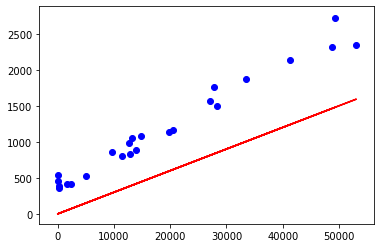

In [219]:
plt.plot(x, model(X, theta), c='r')
plt.scatter(x,y, c='b')

## 4. La fonction de coût
La fonction de coût de l'erreur (à ne pas confondre avec le coût en Euros estimé) est une fonction qui permet de calculer la valeur de l'erreur suite à l'apprentissage.    
Cette fonction de coût est aussi appelée **Erreur Quadratique Moyenne (Mean Squared Error)**.    

En notation matricielle, cette fonction correspond à:    

    COUT = 1/2*m * SOMME((X.THETA - Y)^2)    

avec:     
m = nombre de lignes du dataset    
X = la matrice d'entrée     
THETA = la matrice des paramètres 'a' et 'b'    
Y = la matrice résultat    

In [220]:
def cost_function(X, y, theta):
    m = len(y)
    return (1/(2*m)) * (np.sum((X.dot(theta) - y)**2))

## 5. Les gradients et la descente de gradients
##### Les gradients
Les gradients correspondent au valeur de la tangente en point donné de la courbe représentative de la somme des moindres carrés. Cela correspond à la valeur de la dérivée partielle de ce point.    
En notation matricielle cela correspond à:    

    THETA = 1/m Xt.(X.THETA - Y)
    
avec:    
m = le nombre de lignes du dataset    
Xt = la transposée de X
X = la matrice d'entrée
THETA = la matrice des paramètres 'a' et 'b'
Y = la matrice résultats 

#### La descente de gradient
L'algorithme de la descente de gradient consiste à trouver les valeurs de 'a' et 'b' pour lesquelles la dérivée est nulle.    
C'est un algorithme itératif qui s'exécute avec deux hyperparmètres le **learning rate** qui va définir la taille du pas à effectuer lors de chaque itération et le **nombre d'itérations** à faire.     
A chaque itérations nous récupérons la valeur de l'erreur calculée par la fonction de coût. Cela nous permettra de tracer la courbe d'apprentissage.

In [221]:
def grad(X, y, theta):
    m = len(y)
    return 1/m * X.T.dot(model(X, theta) - y)

In [222]:
def gradient_descent(X, y, theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X,y, theta)
        cost_history[i] = cost_function(X, y, theta)
    return theta, cost_history

## 6. Apprentissage

Paramètres estimés
a: [0.05350093]
b: [0.60000235]


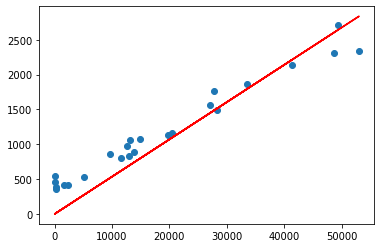

In [224]:
n_iter = 95000
alpha = 0.0000000000001

theta_final, cost_history = gradient_descent(X, y, theta, alpha, n_iter)
print("Paramètres estimés\na: {0}\nb: {1}".format(theta_final[0], theta_final[1]))
predictions = model(X, theta_final)
plt.scatter(x,y)
plt.plot(x, predictions, c='r')

## 7. Courbe d'apprentissage
Cette courbe montre qu'au dela de 40000 itérations l'algorithme n'améliore pas 'a' et 'b'

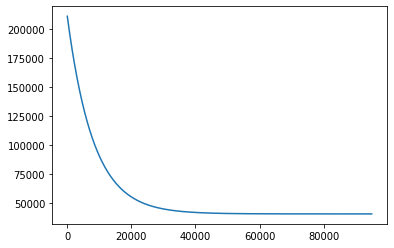

In [225]:
plt.plot(range(n_iter), cost_history)

## 8. Calcul de la précision
La précision de l'estimateur est calculé grâce à la méthode de la somme des moindres carrés (R^2).   
La précision de cet estimateur est de 82.7%. Cette faible précision s'explique par la petite taille du dataset (24).

In [226]:
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return 1 - u/v

In [227]:
print("R^2 = {0}%".format(round(coef_determination(y, predictions)*100,2)))

R^2 = 82.7%


## 9. Test de l'estimateur
Pour tester l'estimateur nous créons une fonction qui va prédire une coût de consommation en fonction de la consommation relevée. 

In [228]:
def predict(v):
    x = v
    x = np.hstack((v, np.ones(x.shape)))
    return model(x, theta_final)

#### Test avec une valeur connue
Pour faire le test, nous prenons une valeur de consommation connue (48327 kWh PCS) et nous la passons dans l'estimateur. Ensuite nous calculons la proportion de la valeur estimée par rapport à la valeur réelle, ce qui nous permet de savoir si la valeur est sous-estimée ou sur-estimée. Si le pourcentage calculé est supérieur à 100% (i.e. supérieur à 1) c'est une sur-estimation si le pourcentage est inférieur à 100% c'est une sous-estimation. L'objectif étant d'atteinde 100% ou de s'en rapprocher.

In [229]:
real_value = 2718.77
v = np.array([49327])
print("Valeur réelle: {0} €\nValeur estimée: {1} €".format(real_value, round(predict(v)[0], 2)))

Valeur réelle: 2718.77 €
Valeur estimée: 2639.64 €


In [230]:
delta = (predict(v)[0] / real_value)
print("{0} %".format(round(delta,2)*100))

97.0 %
